# Food Recognizer

## Description

Dans ce projet nous avons effectuer une classification multi-classe sur 58 types d'aliments; le modèle est entraîîné avec une d'architecture Deep Learning "Inception V3".

## Ressources

* Kernel kaggle : https://www.kaggle.com/theimgclist/multiclass-food-classification-using-tensorflow
* Comprendre l'architecture InceptionV3 : https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
* Mount Drive in Colab : https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
* Recognizing Animals in Photos: Building an AI model for Object Recognition : https://appsilon.com/object-recognition-transfer-learning/
* !!! yolo-for-real-time-food-detection : http://bennycheung.github.io/yolo-for-real-time-food-detection
* Downloading datasets into google drive via google colab : https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

## TODO

* Décrire plus précision le modèle Inception V3 et son architecture : Dropout, ...
* Décrire plus précisément l'évaluation du modèle

# Notebook content

0. Importing Necessary Modules
1. Mount Google Drive to Google Colag
2. Dataset structure
3. Inception pretrained with Food 58 dataset
4. Accuracy and loss plot
5. Predicting classes from new images from the internet using the best train model
6. Object detection test

## 0. Importing Necessary Modules

In [0]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import shutil
from collections import defaultdict
import random
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

## 1. Mount Google Drive to Google Colag

Nous lions notre notebook à Google Drive pour pouvoir utiliser les systèmes de fichiers de Google Drive.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# On se place dans le dossier de travail courant du projet
from google.colab import drive

root_path = '/content/gdrive/My Drive/Portfolio_data/Projet-Food-Reconizer/'  #change dir to your project folder
dataset_file_path = root_path + "g_img_dataset.zip"
# Change path to the working directory
os.chdir(root_path)

## 2. Dataset structure

**The dataset has been build by scraping Google Images**

*   This is a dataset of 29000 (21750 for training and 7250 for validation) food images
*   We have 58 food type categories
*   We have a train and test folder who each contains 58 folder (58 categories) with 375 images train folder and 125 images for test folder.



In [0]:
#Unzip the images dataset - Uncomment and execute if the dataset has not been unzip
# !jar xvf g_img_dataset.zip

In [5]:
# sample of food classes.
os.listdir("src/g_img_dataset/test")[:10]

['steak',
 'pulled_pork',
 'beef_carpaccio',
 'filet_mignon',
 'baby_back_ribs',
 'beef_tartare',
 'chicken_curry',
 'chicken_wings',
 'peking_duck',
 'pork_chop']

**"meta"** folder contains the text and json files :
<br>
* **food_classes.txt :** contains the list of all classes of food
* **food_labels.txt :** contains the list of all labels of food
* **train.txt :** contains the list of images that belong to training set  
* **test.txt :** contains the list of images that belong to test set  
* **train.json :** contains the list of images that belong to training set in json format
* **test.json :** contains the list of images that belong to test set in json format



In [6]:
!ls -la src/g_img_dataset/meta/ | awk '{print $8,$9}'

 
16:30 food_classes.txt
14:29 food_labels.txt
08:56 test.json
08:47 test.txt
09:00 train.json
08:47 train.txt


In [7]:
!head src/g_img_dataset/meta/train.json

  {"type":"directory","name":"train","contents":[
    {"type":"directory","name":"almonds","contents":[
      {"type":"file","name":"0079effae1.jpg"},
      {"type":"file","name":"008aa0051f.jpg"},
      {"type":"file","name":"00919ad24d.jpg"},
      {"type":"file","name":"04d58d03c2.jpg"},
      {"type":"file","name":"0505784391.jpg"},
      {"type":"file","name":"05e3c0a3b7.jpg"},
      {"type":"file","name":"065f067e49.jpg"},
      {"type":"file","name":"074de20f1d.jpg"},


In [8]:
!head src/g_img_dataset/meta/train.txt

green_beans/3405b582f4.jpg
green_beans/459944d323.jpg
green_beans/64386f633f.jpg
green_beans/3c095b8805.jpg
green_beans/6a6ca6227d.jpg
green_beans/85801796fc.jpg
green_beans/1a748f420f.jpg
green_beans/3582e7b806.jpg
green_beans/5dc45fd661.jpg
green_beans/12cabb101f.jpg


In [9]:
!head src/g_img_dataset/meta/food_classes.txt

['blackberries',
 'cantaloupe',
 'blueberries',
 'cherries',
 'peach',
 'kiwi',
 'clementine',
 'plum',
 'raspberries',
 'strawberries',


In [10]:
!head src/g_img_dataset/meta/food_labels.txt

'Blackberries',
 'Cantaloupe',
 'Blueberries',
 'Cherries',
 'Peach',
 'Kiwi',
 'Clementine',
 'Plum',
 'Raspberries',
 'Strawberries',


**Liste de modèles entrainés**<br>
Le dataset contient une liste de modèles entrainés<br>

In [11]:
!find src/g_img_dataset/trained_models/

src/g_img_dataset/trained_models/
src/g_img_dataset/trained_models/best_model_58class_all.hdf5
src/g_img_dataset/trained_models/model_trained_58class_all.hdf5


**Visualize some images**

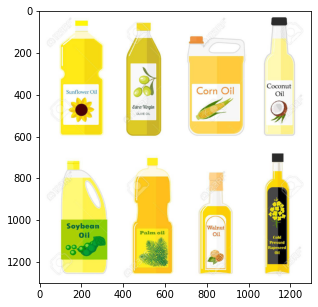

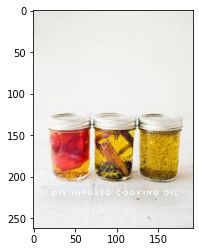

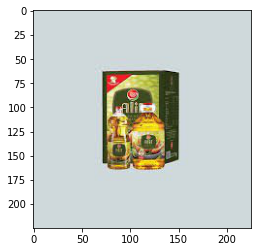

In [12]:
lst_images = os.listdir("src/g_img_dataset/train")
idx = np.random.randint(len(lst_images))
food_type = lst_images[idx]
lst_food_type_images = os.listdir(f"src/g_img_dataset/train/{food_type}")
image_path = f"src/g_img_dataset/train/{food_type}"

plt.figure(figsize=(5, 5))
for i in range(3):
  img = plt.imread(f"{image_path}/{lst_food_type_images[np.random.randint(len(lst_food_type_images))]}")
  plt.imshow(img)
  plt.show()
  

In [13]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find src/g_img_dataset/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
1
21750


In [0]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find src/g_img_dataset/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
7250


## 3. Inception pretrained with Food 58 dataset

In [0]:
## A dé-commenter pour entrainer le modèle
# K.clear_session()
# n_classes = 58
# img_width, img_height = 299, 299
# train_data_dir = "src/g_img_dataset/train"
# validation_data_dir = "src/g_img_dataset/test"
# nb_train_samples = 21750
# nb_validation_samples = 7250
# batch_size = 16

# # augmentation configuration use for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(  
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode="categorical")

# validation_generator = test_datagen.flow_from_directory(  
#         validation_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode="categorical")

# inception = InceptionV3(weights='imagenet', include_top=False)
# x = inception.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation="relu")(x)
# x = Dropout(0.2)(x)
# predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation="softmax")(x)

# model = Model(inputs=inception.input, outputs=predictions)
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])
# checkpointer = ModelCheckpoint(filepath="best_model_58class_all.hdf5", verbose=1, save_best_only=True)
# csv_logger = CSVLogger("history_58class_all.log")
# earlyStopping = [EarlyStopping(monitor="val_loss", patience=10)]

# history = model.fit_generator(
#     train_generator, 
#     steps_per_epoch=nb_train_samples // batch_size,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
#     epochs=30,
#     verbose=1,
#     callbacks=[csv_logger, checkpointer, earlyStopping]
# )

# model.save("model_trained_101class_58class_all.hdf5")

## 4. Accuracy and loss plot

In [14]:
df_history = pd.read_csv("src/history_58class_all.log")
df_history.tail(5)

,epoch,accuracy,loss,val_accuracy,val_loss
25,25,0.899328,0.676142,0.844647,0.865736
26,26,0.907058,0.649580,0.848234,0.855357
27,27,0.913960,0.615745,0.849890,0.840163
28,28,0.920171,0.595836,0.854581,0.831913
29,29,0.925278,0.577421,0.854305,0.825411


In [0]:
def plot_accuracy(history, title):
  plt.title(title)
  plt.plot(history["accuracy"])
  plt.plot(history["val_accuracy"])
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train_accuracy", "validation_accuracy"], loc="best")
  plt.show()

def plot_loss(history, title):
  plt.title(title)
  plt.plot(history["loss"])
  plt.plot(history["val_loss"])
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train_loss", "validation_loss"], loc="best")
  plt.show()  

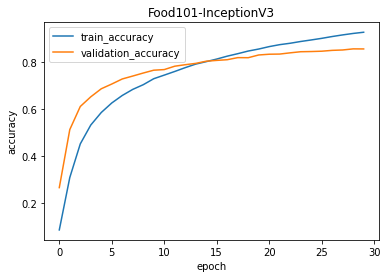

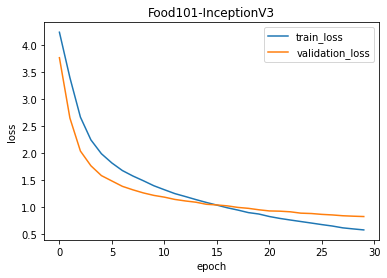

In [0]:
plot_accuracy(df_history, "Food101-InceptionV3")
plot_loss(df_history, "Food101-InceptionV3")

* Accuracy increased with epochs and the loss decreased
* Validation accuracy has been on higher side than training accuracy for many epochs; this could be for several reason : 
  * due to the used of pre-trained model on ImageNet ...
  * Using Dropout can lead to a higher validation accuracy

## 5. Predicting classes from new images from the internet using the best train model

In [0]:
# Load the best save model to make predictions
K.clear_session()
model_best = load_model("src/best_model_58class_all.hdf5", compile=False)

* clearing session and set compile=False leads to faster loading
* 

In [0]:
# Download validation images
# !wget -O src/g_img_dataset/validation/sarvice.jpg https://p1.storage.canalblog.com/13/02/410020/86561910_p.jpg

--2020-05-09 10:51:34--  https://p1.storage.canalblog.com/13/02/410020/86561910_p.jpg
Resolving p1.storage.canalblog.com (p1.storage.canalblog.com)... 195.137.184.178, 195.137.184.180
Connecting to p1.storage.canalblog.com (p1.storage.canalblog.com)|195.137.184.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40409 (39K) [image/jpeg]
Saving to: ‘src/g_img_dataset/sarvice.jpg’

src/g_img_dataset/s 100%[===================>]  39.46K  --.-KB/s    in 0.1s    

2020-05-09 10:51:34 (386 KB/s) - ‘src/g_img_dataset/sarvice.jpg’ saved [40409/40409]



In [0]:
def predict_class(model, images, show=True):
  for img in images:
    # print(img)
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list = os.listdir("src/g_img_dataset/test")
    food_list.sort()
    pred_value = food_list[index]
    if show:
      plt.imshow(img[0])
      plt.axis("off")
      plt.title(pred_value)
      plt.show()

In [0]:
images = []
for file_name in os.listdir("src/g_img_dataset/validation"):
    images.append(f'src/g_img_dataset/validation/{file_name}')

print(images)    
predict_class(model_best, images, True)

Output hidden; open in https://colab.research.google.com to view.